# 历史旱涝数据说明



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
import os
from hydra import compose, initialize

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from shifting_baseline.data import HistoricalRecords
from mksci_font import config_font

# 设置seaborn风格
sns.set_style("ticks")
sns.set_context("paper")
config_font({"font.size": 9})

# The commented out code is creating an instance of the `HistoricalRecords` class from the `shifting_baseline.api.series` module. It is passing the `shp_path` and `data_path` parameters to the constructor of `HistoricalRecords` class using values from `cfg.ds.atlas.shp` and `cfg.ds.atlas.file` respectively.
history = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
    to_std="sampling",
)

/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:213: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


# 对比重建数据和历史数据

- 历史数据来自《中国千年旱涝图集》
- 重建数据来自 NOAA 的树轮重建数据


Millennial-scale data reveals collective memory of extreme events The impact of extreme weather events such as droughts and floods is intensifying, one important reason being that society quickly forgets past disasters and develops in disaster-prone areas. This collective memory of disasters has significantly affected a society's vulnerability to them. Still, there has long been a lack of data-driven measurements on how long this collective memory lasts. For the first time, we compared historical records with natural reconstructions over a millennium scale in China's Yellow River Basin, demonstrating that the collective memory of extreme climate lasts about 30 years (two generations). The current Earth System Models (ESMs), however, can not have sufficient spatial and temporal resolution to match this pattern, failing to capture the interactions between humans and extreme events. This finding emphasised the necessity of coupling environmental changes with human social systems and improving ESMs for the deep root of the Anthropocene.

## NOAA 树轮重建数据

In [4]:
combined = pd.read_csv(cfg.ds.out.tree_ring, index_col=0)
combined.head()

,mean,sd,hdi_3%,hdi_97%
year,,,,
1000,0.296,0.519,-0.658,1.283
1001,-0.022,0.540,-0.956,1.078
1002,0.781,0.624,-0.434,1.937
1003,0.428,0.673,-0.889,1.641
1004,-0.221,0.654,-1.491,0.952


这里我们还可以用一张综合图来说明情况。

由于一般需要5个样本，计算标准差才有意义，所以我们的 `min_periods` 参数比 `windows` 至少要小 5。













/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:213: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


开始计算历史数据和重建数据的相关性
cfg.agg_method=mean; cfg.to_int=True.


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/utils/plot.py:292: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


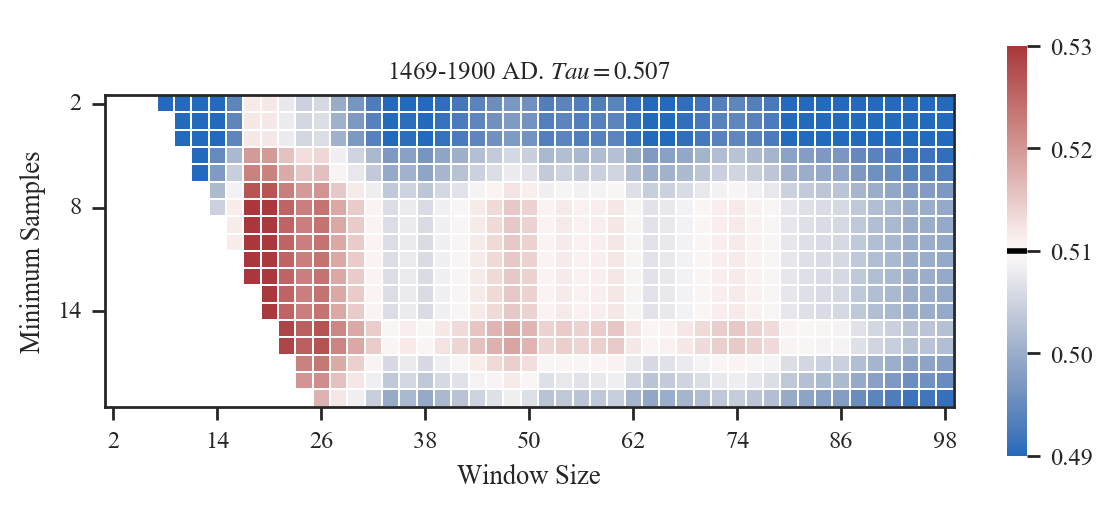

In [5]:
from shifting_baseline.compare import experiment_corr_2d
from shifting_baseline.constants import STAGE1, STAGE2, END
from shifting_baseline.filters import calc_std_deviation

history.setup()
# 实验参数
slice_now = slice(STAGE1, END)

print("开始计算历史数据和重建数据的相关性")
print(f"cfg.agg_method={cfg.agg_method}; cfg.to_int={cfg.to_int}.")
data1, data2 = history.aggregate(
    cfg.agg_method,
    inplace=True,
    to_int=cfg.to_int,
).merge_with(
    combined["mean"],
    time_range=slice_now,
    split=True,
)

fig, ax = plt.subplots(1, 1, figsize=(6, 2.5), tight_layout=True)
df, r_benchmark, ax = experiment_corr_2d(
    data1=data1,
    data2=data2,
    time_slice=slice_now,
    corr_method=cfg.corr_method,
    filter_func=calc_std_deviation,
    filter_side=cfg.filter_side,
    ax=ax,
    n_diff_w=5,
    std_offset=0.1,
)
ax.set_title(
    f"{slice_now.start}-{slice_now.stop} AD. $Tau={r_benchmark:.3f}$",
    fontsize=9,
)
ax.locator_params(axis="x", nbins=9)  # x轴最多9个主刻度
ax.locator_params(axis="y", nbins=4)  # y轴最多9个主刻度
ax.tick_params(axis="both", rotation=0)
plt.show();

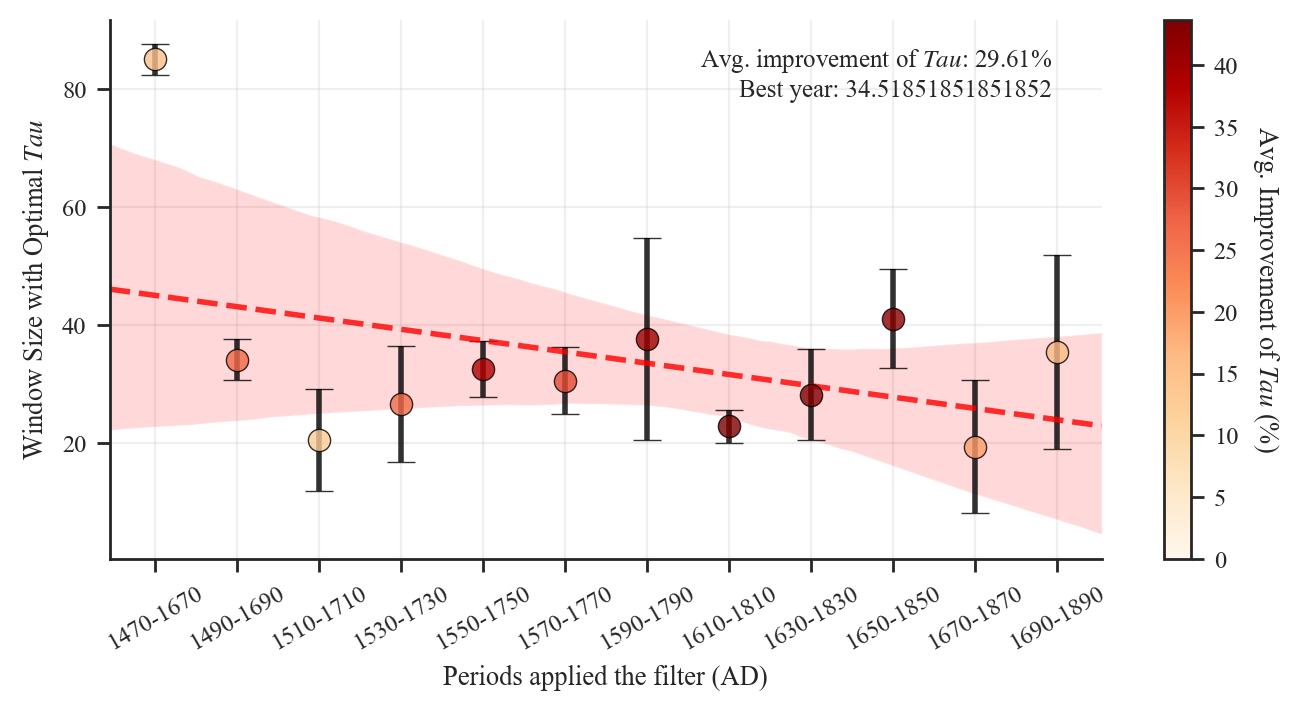

In [15]:
from shifting_baseline.compare import sweep_slices
from shifting_baseline.filters import calc_std_deviation
from shifting_baseline.compare import sweep_max_corr_year

import matplotlib.pyplot as plt
from shifting_baseline.utils.plot import plot_correlation_windows

slices, mid_year, slice_labels = sweep_slices(
    start_year=1470,
    window_size=200,
    step_size=20,
    end_year=END,
)

data1, data2 = history.merge_with(
    combined["mean"],
    split=True,
)
max_corr_year, max_corr = sweep_max_corr_year(
    data1=data1,
    data2=data2,
    slices=slices,
    corr_method=cfg.corr_method,
    windows=np.arange(2, 100),
    min_periods=np.repeat(cfg.min_period, 98),
    filter_func=calc_std_deviation,
)

# 使用函数
ax = plot_correlation_windows(
    max_corr_year,
    max_corr,
    mid_year,
    slice_labels,
)
lims = ax.get_xlim()
ax.set_xlim(lims)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
mean_improvement = np.stack(max_corr).mean()
best_year = np.stack(max_corr_year).mean()
ax.text(
    0.95,
    0.95,
    f"Avg. improvement of $Tau$: {mean_improvement:.2%}\nBest year: {best_year}",
    ha="right",
    va="top",
    transform=ax.transAxes,
)
plt.show();

### 箱线图

In [7]:
from shifting_baseline.compare import compare_corr
from shifting_baseline.utils.calc import rand_generate_from_std_levels
from shifting_baseline.constants import STAGE1, END
from shifting_baseline.filters import classify

temp_hist = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
    to_std=None,
)

ds = rand_generate_from_std_levels(temp_hist.data, n_samples=100)
ds = np.nanmean(ds, axis=2)

rolling_kwargs = {
    "window": 30,
    "min_periods": cfg.min_period,
}

filtered_corr_list = []
benchmark_corr_list = []
for i in range(ds.shape[0]):
    pred = pd.Series(ds[i, :], index=temp_hist.data.index).loc[STAGE1:END]
    true = pd.Series(combined["mean"].loc[STAGE1:END])
    filtered_r, filtered_p, _ = compare_corr(
        classify(pred, handle_na="skip"),
        true,
        window_error="raise",
        filter_func=calc_std_deviation,
        filter_side=cfg.filter_side,
        corr_method=cfg.corr_method,
        n_diff_w=5,
        **rolling_kwargs,
    )
    benchmark_r, benchmark_p, _ = compare_corr(
        classify(pred, handle_na="skip"),
        true,
        corr_method=cfg.corr_method,
    )
    filtered_corr_list.append(filtered_r if filtered_p < 0.05 else np.nan)
    benchmark_corr_list.append(benchmark_r if benchmark_p < 0.05 else np.nan)

ds = pd.DataFrame(
    {
        "Filtered": filtered_corr_list,
        "Original": benchmark_corr_list,
    }
)
ds.head()

/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_99717/3223799745.py:14: RuntimeWarning: Mean of empty slice
  ds = np.nanmean(ds, axis=2)


,Filtered,Original
0,0.491754,0.493578
1,0.498137,0.508854
2,0.497623,0.503727
3,0.494980,0.494415
4,0.511402,0.516308


Text(0, 0.5, "Kendall's Tau")

1.6328286415706512e-12

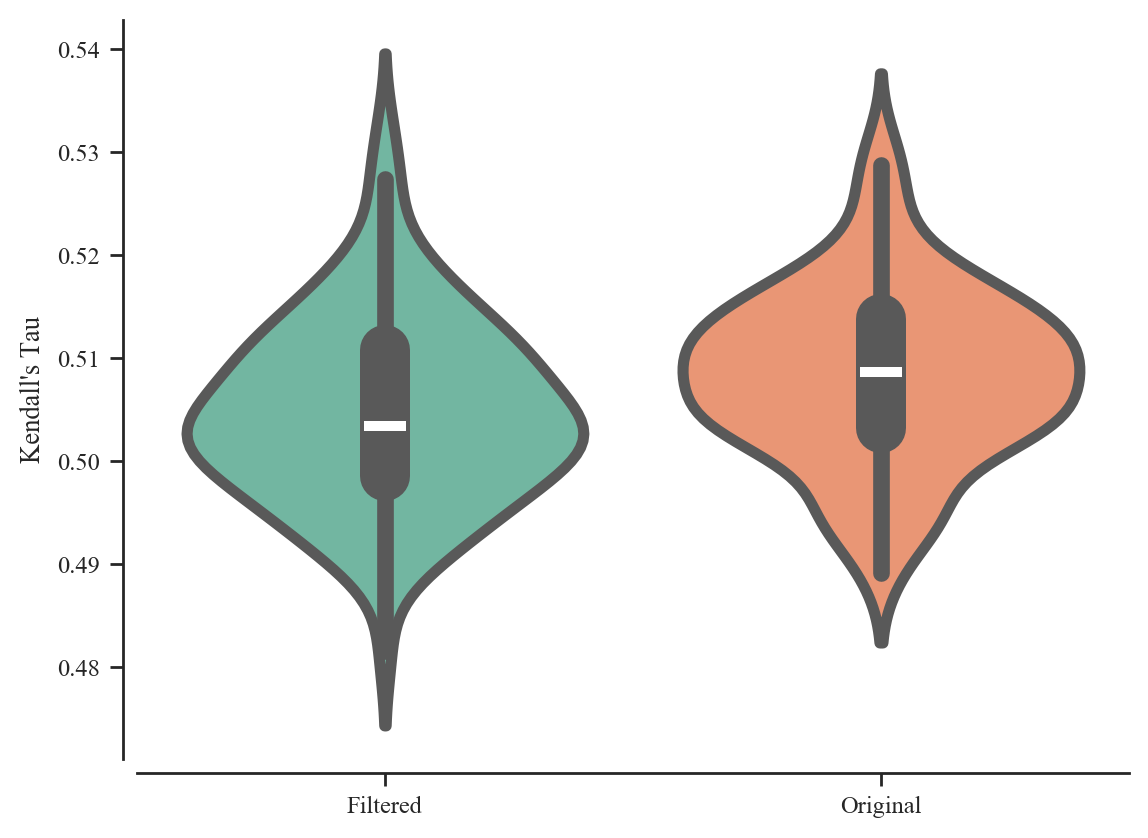

In [8]:
from scipy.stats import ttest_rel

ax = sns.violinplot(data=ds, palette="Set2", linewidth=4)
ax.set_ylabel("Kendall's Tau")
sns.despine(ax=ax, offset=5)
ttest = ttest_rel(ds.iloc[:, 0], ds.iloc[:, 1])
ttest.pvalue

### 综合作图

/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/utils/plot.py:292: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


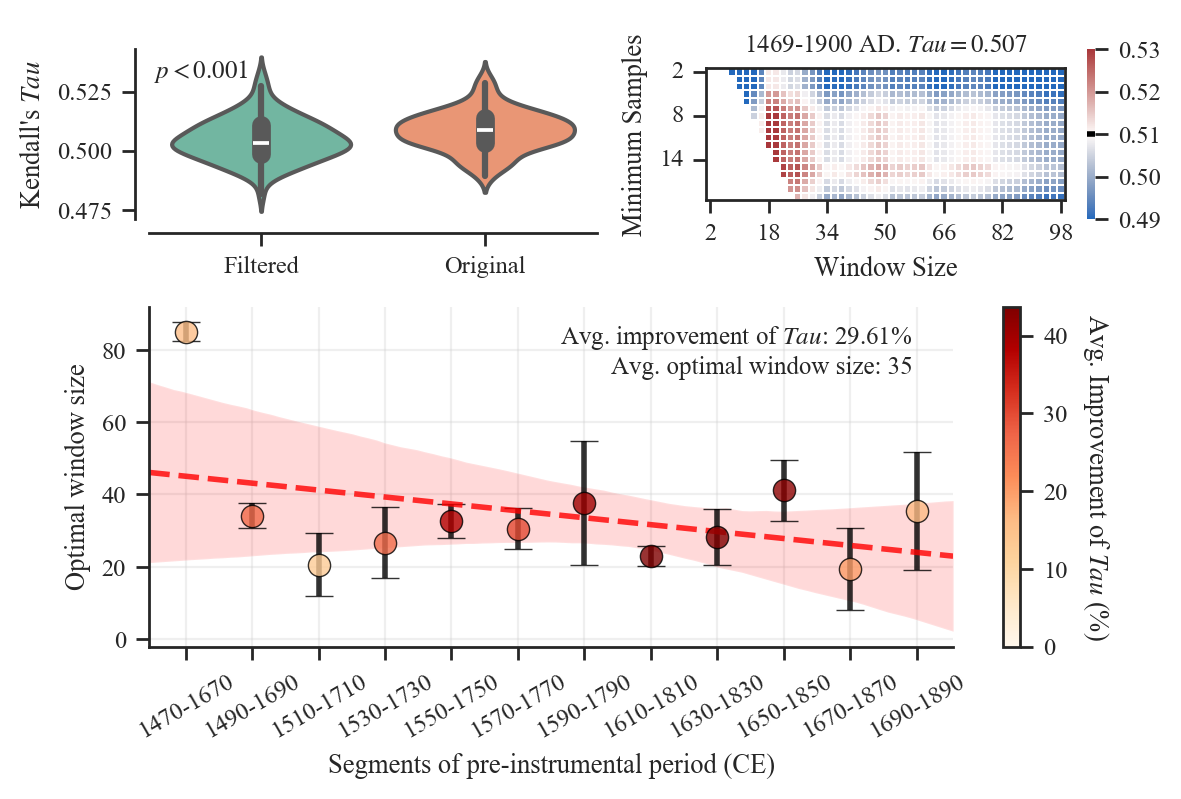

In [17]:
fig = plt.figure(figsize=(6, 4), constrained_layout=False)  # 增加高度

gs = fig.add_gridspec(ncols=2, nrows=2, height_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0, 1])

df, r_benchmark, ax1 = experiment_corr_2d(
    data1=data1,
    data2=data2,
    time_slice=slice_now,
    corr_method=cfg.corr_method,
    filter_func=calc_std_deviation,
    filter_side=cfg.filter_side,
    ax=ax1,
    n_diff_w=5,
    std_offset=0,
)
ax1.set_title(
    f"{slice_now.start}-{slice_now.stop} AD. $Tau={r_benchmark:.3f}$",
    fontsize=9,
)
ax1.locator_params(axis="x", nbins=9)  # x轴最多9个主刻度
ax1.locator_params(axis="y", nbins=4)  # y轴最多9个主刻度
ax1.tick_params(axis="both", rotation=0)


# 绘制箱线图
ax2 = fig.add_subplot(gs[0, 0])
sns.violinplot(data=ds, ax=ax2, palette="Set2", linewidth=1.5)
sns.despine(ax=ax2, offset=5)
ax2.set_ylabel("Kendall's $Tau$")
ax2.text(0.01, 0.95, "$p<0.001$", ha="left", va="top", transform=ax2.transAxes)
#### ================================================
ax3 = fig.add_subplot(gs[1, :])

# 绘制不同历史时期的窗口图
ax3 = plot_correlation_windows(
    max_corr_year,
    max_corr,
    mid_year,
    slice_labels,
    ax=ax3,
)
lims = ax3.get_xlim()
# ax3.axvspan(1636, 1720, color="gray", alpha=0.2, label="Dynasty Transition")


mean_improvement = np.stack(max_corr).mean()
best_year = np.stack(max_corr_year).mean()
ax3.text(
    0.95,
    0.95,
    f"Avg. improvement of $Tau$: {mean_improvement:.2%}\nAvg. optimal window size: {best_year:.0f}",
    ha="right",
    va="top",
    transform=ax3.transAxes,
)
ax3.set_xlim(lims)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.set_xlabel("Segments of pre-instrumental period (CE)")
ax3.set_ylabel("Optimal window size")
plt.tight_layout()
plt.show();